# Housing Prices Competition for Kaggle Learn Users, grajenje modelov

# Uvod

V tej skripti se ukvarjamo z regresijskim problemom napovedovanja cen na podlagi različnih vhodnih značilk, kot je bil predstavljen v Kaggle izzivu. Za gradnjo modelov uporabljamo popularne knjižnice, kot so scikit-learn, XGBoost, CatBoost in LightGBM. Namen je preizkusiti različne regresijske pristope – od preprostih linearnih modelov do kompleksnejših ansambelskih metod, kot sta VotingRegressor in StackingRegressor, s ciljem izboljšati natančnost napovedi in zmanjšati napake. Posebno pozornost namenjamo tudi pripravi in čiščenju podatkov ter odstranjevanju odvečnih vhodnih spremenljivk, da optimiziramo rezultate modelov.

In [118]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import  ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [119]:
train_df = pd.read_csv("./Podatki/train.csv")
test_df = pd.read_csv("./Podatki/test.csv")

# Čiščenje podatkov

V tem delu kode smo odstranili osamelce in nadomestili manjkajoče vrednosti (večinoma s 'No'), saj v nekaterih primerih vrednost NaN pomeni, da določena lastnost pri objektu ni prisotna, ne pa da podatka dejansko ni ali je neznan. Počistili smo pa tudi podatke v atributih, ki imajo visoko koleracijo.

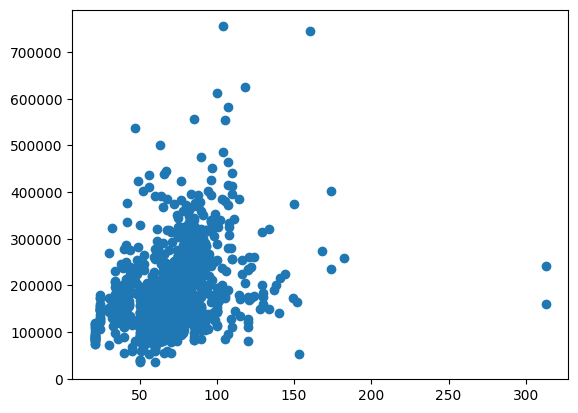

In [121]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_df)
# LotFrontage: Linear feet of street connected to property

In [ ]:
train_df.query('LotFrontage > 300')
# Tukaj smo pregledali nekatere pomembne atribute kot LotArea, LotFrontage in izbrisal najdene osmalece
# 935, 1299, 250, 314, 336, 707, 
# morda: 1397.

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MoSold,SaleType,SaleCondition,SalePrice,houseAge,houseRemodelAge,totalSF,totalArea,totalBaths,totalPorchSF


In [ ]:
z_scores = pd.Series(stats.zscore(train_df['LotArea']))
z_scores.sort_values(ascending=False).head(10)
# iskanje z scora (za koliko std je daleč od povprečja)

313     20.518273
335     15.448542
249     14.881285
706     10.486449
451      6.037793
1298     5.348867
1396     4.678682
769      4.308262
457      4.280500
384      4.268474
dtype: float64

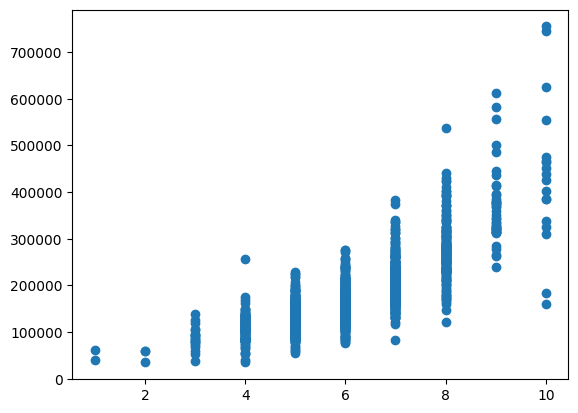

In [ ]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


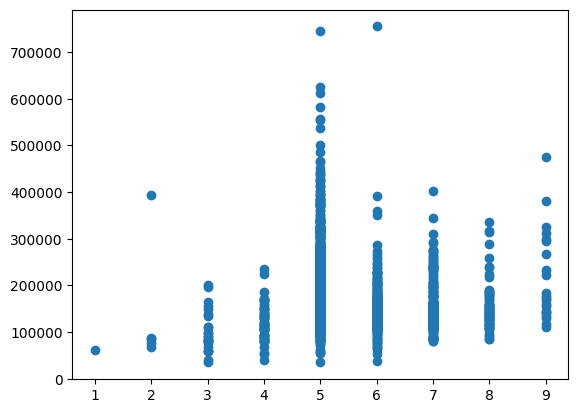

In [ ]:
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)
train_df.query('OverallCond == 6 & SalePrice > 700000')
# ni tako pomemben atribut
# 379, 1183, 692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


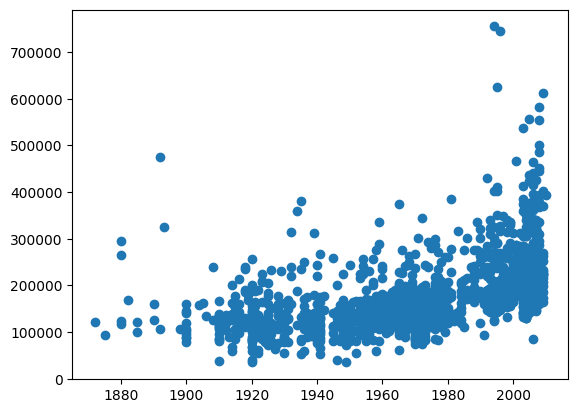

In [ ]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)
train_df.query('YearBuilt < 1900 & SalePrice > 400000')
# 186

In [ ]:
# Pri odstranjevanju osamelcev je treba biti previden, saj nekateri izmed njih lahko vsebujejo pomembne informacije, ki so koristne za modeliranje
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [ ]:
# Odstranimo zapisane osamelce
train_df = train_df[train_df.Id.isin(values) == False]

In [ ]:
# Pregled null vrednosti
train_df_arranged = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
train_df_arranged.head(20)
# Te lahko nadomestimo s povprečnimi vrednostimi ali jih odstranimo.

,0
PoolQC,1435
MiscFeature,1388
Alley,1350
Fence,1162
MasVnrType,861
FireplaceQu,684
LotFrontage,255
GarageYrBlt,76
GarageCond,76
GarageType,76


In [ ]:
objectAtrib = ['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'GarageCond', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtQual', 'BsmtCond']
# BsmtExposure
intAtrib = ['MasVnrArea', 'LotFrontage']
unfAtrib = ['BsmtFinType1', 'BsmtFinType2']

for atrib in objectAtrib:
    train_df[atrib].fillna('No', inplace=True)
    test_df[atrib].fillna('No', inplace=True)

for atrib in intAtrib:
    train_df[atrib].fillna(0, inplace=True)
    test_df[atrib].fillna(0, inplace=True)

for atrib in unfAtrib:
    # Unf - unfinished
    train_df[atrib].fillna('Unf', inplace=True)
    test_df[atrib].fillna('Unf', inplace=True)

# SBrkr	Standard Circuit Breakers & Romex
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)


C:\Users\rokri\AppData\Local\Temp\ipykernel_39580\764662866.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[atrib].fillna('No', inplace=True)
C:\Users\rokri\AppData\Local\Temp\ipykernel_39580\764662866.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


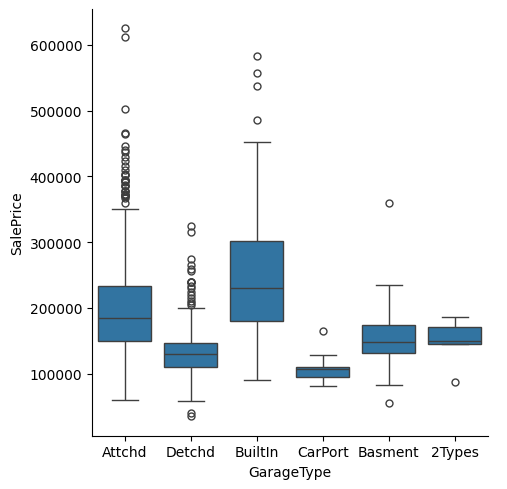

In [131]:
#Blok kode samo za testiranje
sns.catplot(data=train_df, x="GarageType", y="SalePrice", kind="box")
print(train_df['GarageType'].unique())
# TA -typicall

In [ ]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
# Fence, Alley, garage atributi, BsmFinType

# Feature engineering

V tem delu smo skupaj ustvarjali različne nove funkcije (feature engineering) in jih testirali. Cilj je bil odstraniti odvečne vhodne spremenljivke ter optimizirati nabor atributov za čim boljši rezultat modela. Pri poimenovanju novih funkcij smo prve črke namenoma zapisali z malo začetnico, da jih lažje prepoznamo kot dodane med procesom.

In [133]:
train_df['houseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseAge'] = test_df['YrSold'] - test_df['YearBuilt']

In [134]:
train_df['houseRemodelAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseRemodelAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [135]:
train_df['totalSF'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalSF'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']
# sf - square feet

In [136]:
train_df['totalArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [137]:
#Šteilo kopalnic štej 0.5 za samo polovočne kopalnice
train_df['totalBaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalBaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [138]:
train_df['totalPorchSF'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalPorchSF'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [139]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

<Axes: >

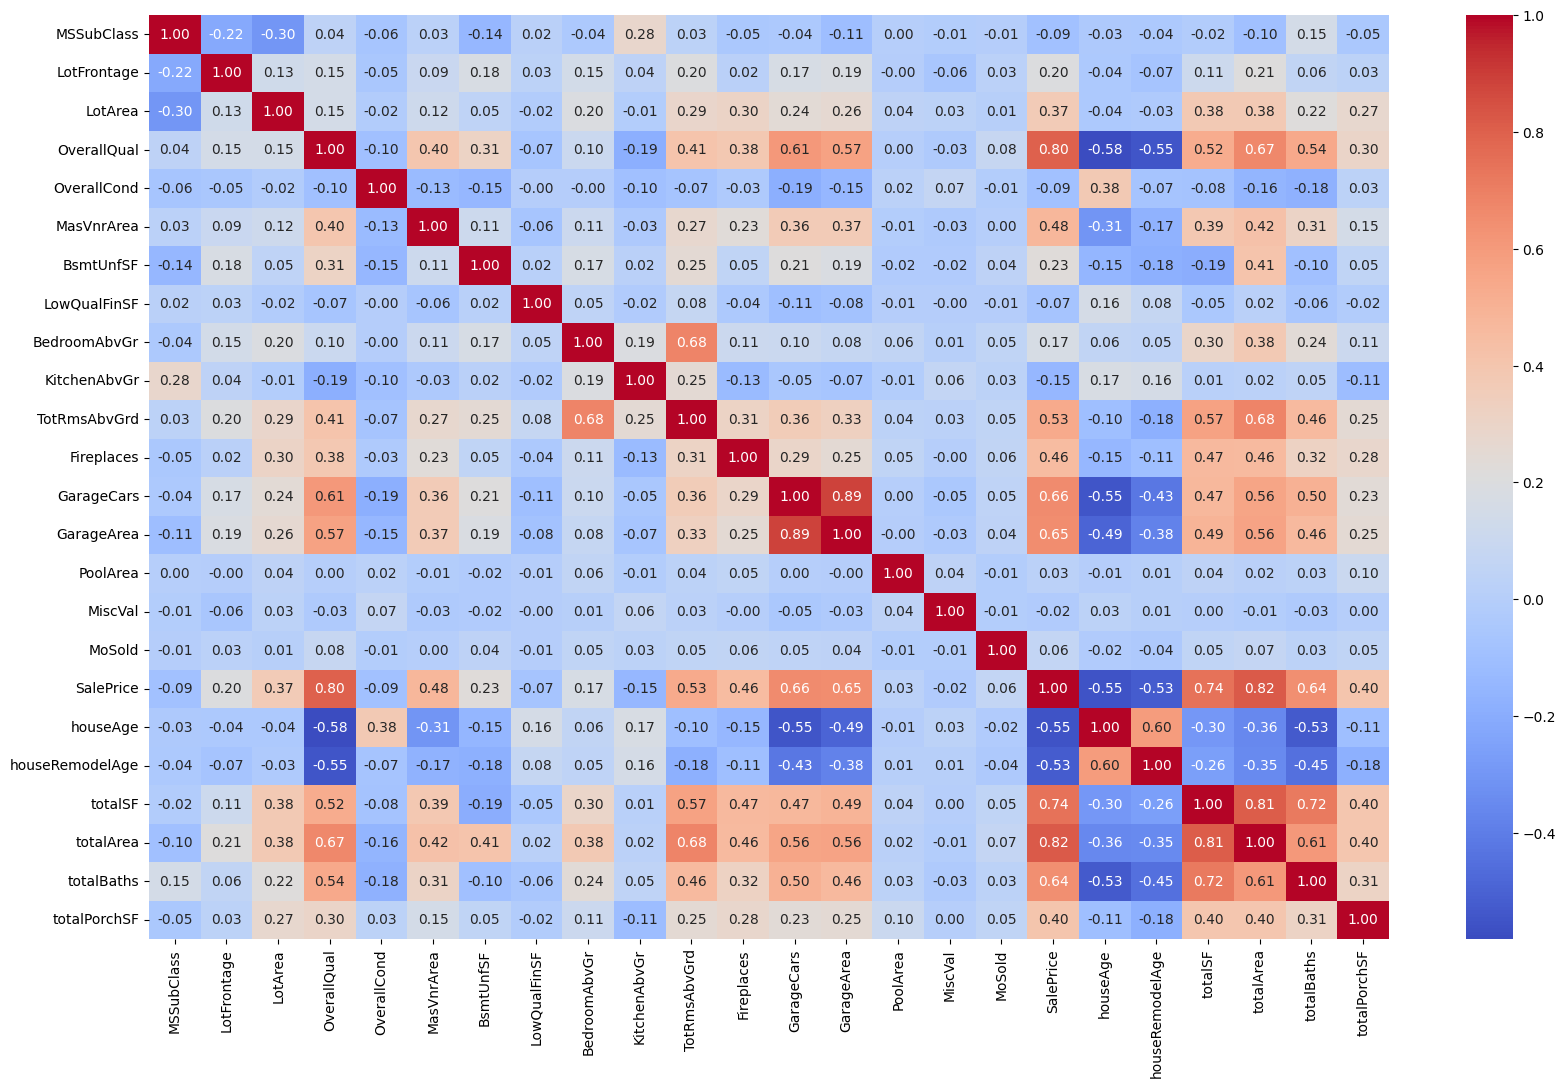

In [140]:
# korelacija nvega 
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [141]:
# GarageArea ali GarageCars. Pazi GrageArea ima še nekaj outlierjov (vsaj zgledajo)
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

<Axes: xlabel='SalePrice', ylabel='Count'>

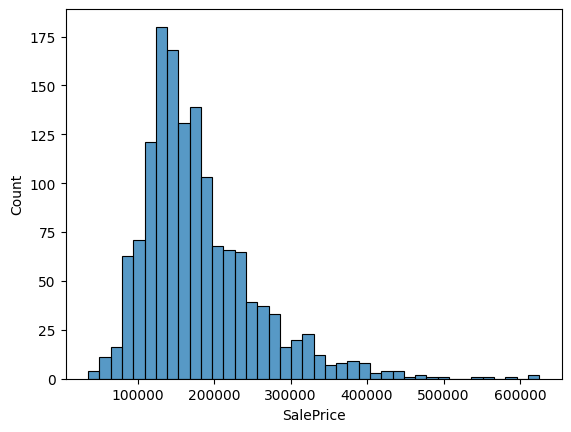

In [142]:
sns.histplot(train_df, x=train_df['SalePrice'])
# asimetrično

V prejšnem zagovoru smo omenili, da bomo naredili log transformacijo nad SalePrice. 
To je transformacija, ki se znebi asimetrije v atributu in zgleda veliko bolje normalno porazdeljena.

log1p = ln(1 + x)

<Axes: xlabel='SalePrice', ylabel='Count'>

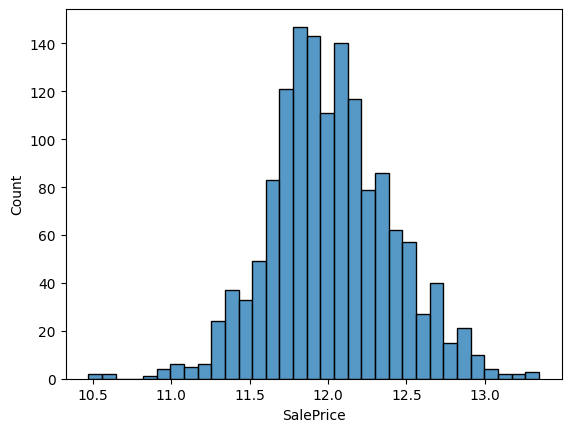

In [143]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.histplot(train_df, x=train_df['SalePrice'])

Tukaj bomo vse objektne (kategorijske) spremenljivke pretvorili v ordinalne ali one-hot kodirane spremenljivke, saj regresorjem ne moremo neposredno posredovati neskupinskih (besedilnih) vrednosti

In [144]:
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [145]:
train_df.dtypes[train_df.dtypes!='object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
houseAge             int64
houseRemodelAge      int64
totalSF              int64
totalArea            int64
totalBaths         float64
totalPorchSF         int64
dtype: object

In [146]:
# Ordinal - Vrstni red je pomemben
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [147]:
# One hot - Vrstni red ni pomemen
# OneHotEndcoding bo naredil nove columne za vsakega (pretvori v svojo binarni stolpec: 1 če je vrednost in 0 če ni) 
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [148]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [149]:
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea',
       'MiscVal', 'MoSold', 'houseAge', 'houseRemodelAge', 'totalSF',
       'totalArea', 'totalBaths', 'totalPorchSF'],
      dtype='object')

In [150]:
# Ustvarjam pipeline, da pretvorimo podatke
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [151]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [152]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [153]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [154]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [155]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [156]:
X_preprocessed = pipeline.fit_transform(X)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

# Grajenje modelov

Uporabili smo preprosto linearno regresijo (LinearRegression), ki predpostavlja linearno povezavo med vhodnimi značilkami in ciljno ceno, ter Ridge regresijo, ki doda L2 regularizacijo za omejevanje velikosti koeficientov. Poleg tega smo preizkusili več metod na drevesni osnovi: Random Forest Regressor (ansambel naključno izbranih dreves), Gradient Boosting Regressor (sekvenčno gradnjo šibkih dreves), XGBoost Regressor (izboljšano izvedbo gradientnega boostanja) in LightGBM Regressor (hitro, ‘leaf-wise’ gradientno boostanje). CatBoost Regressor je samodejno obdelal kategorizirane spremenljivke, medtem ko sta Voting Regressor in Stacking Regressor združila napovedi več modelov z namenom povečati stabilnost in natančnost

In [158]:
lr = LinearRegression()

In [159]:
lr.fit(X_train, y_train)

LinearRegression()

In [160]:
y_pred_lr = lr.predict(X_test)

In [161]:
np.sqrt(mean_squared_error(y_test, y_pred_lr))

0.13330937939601525

In [162]:
RFR = RandomForestRegressor(random_state=13)

In [163]:
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [164]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [165]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [166]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13388237002419306

In [167]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [168]:
XGB = XGBRegressor(random_state=13)

In [169]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [170]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [171]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [172]:
np.sqrt(-1 * xgb_cv.best_score_)

0.11882762732959468

In [173]:
ridge = Ridge()

In [174]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [175]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [176]:
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [177]:
np.sqrt(-1 * ridge_cv.best_score_)

0.10905460909043639

In [178]:
GBR = GradientBoostingRegressor()

In [179]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [180]:
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [181]:
GBR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [182]:
np.sqrt(-1 * GBR_cv.best_score_)

0.11311266834154768

In [183]:
# Z lgbm regresorjem so bile neke težave zato, ga morda nebomo uporabil v streamlib.
lgbm_regressor = lgb.LGBMRegressor()

In [184]:
param_grid_lgbm = {
    'boosting_type': ['gbdt'],
    'num_leaves': [20, 31],
    'learning_rate': [0.05],
    'n_estimators': [100, 200]
}

In [185]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [186]:
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1992
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 111
[LightGBM] [Info] Start training from score 12.023259


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'learning_rate': [0.05],
                         'n_estimators': [100, 200], 'num_leaves': [20, 31]},
             scoring='neg_mean_squared_error')

In [187]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.12762378359233006

In [188]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [189]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}


In [190]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [191]:
cat_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F767330850>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [192]:
np.sqrt(-1 * cat_cv.best_score_)

0.11486362424082305

In [193]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [194]:
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=15,
                                                       max_features=0.1,
                                                       min_samples_leaf=25,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None, ...)),
                            ('ridge', Ridge(alpha=5, solver='lsqr'))],
                weights=[2, 3, 1])

In [195]:
y_pred_vr = vr.predict(X_test)

In [196]:
np.sqrt(mean_squared_error(y_test, y_pred_vr))

0.11649862036573001

In [ ]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [198]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [199]:
stackreg.fit(X_train, y_train)

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=15,
                                                         max_features=0.1,
                                                         min_samples_leaf=25,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            importance_type=None,
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.05,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=1,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=5,
                                                                     solver='lsqr'))],
                                                  weights=[2, 3, 1]))

In [200]:
y_pred_stack = stackreg.predict(X_test)

In [201]:
np.sqrt(mean_squared_error(y_test, y_pred_stack))

0.11373510917504559

Rezultati RMSE na testnem naboru kažejo, da je najboljše napovedi dosegla Ridge regresija z RMSE 0.10905, kar pomeni najmanjšo povprečno absolutno napako v logaritemsko transformirani ciljni spremenljivki. Sledili so Gradient Boosting Regressor (0.11328), Stacking Regressor (0.11373) in CatBoost Regressor (0.11486), ki prav tako zelo dobro ujamejo nelinearne relacije. Voting Regressor (0.11670) je združil sile več modelov, XGBoost (0.11882) in LightGBM (0.12762) sta dosegla solidne, a nekoliko višje napake, medtem ko sta končni mesti zasedla Linear Regression (0.13330) in Random Forest Regressor (0.13388).

### Napovedovanje in shranjevanje rezultatov

V tem delu kode testne podatke najprej predobdelamo z uporabo naučenega predprocesnega pipeline. Nato z že usposobljenim stackreg modelom napovemo vrednosti ciljnega atributa. Ker je model treniran na logaritmu cene, rezultate pretvorimo nazaj z eksponentno funkcijo. Nato ustvarimo rezultatni DataFrame, ki vsebuje identifikacijske številke in napovedane cene, ter ga shranimo kot CSV datoteko submission.csv za nadaljnjo uporabo ali oddajo na tekmovalni platformi.

In [202]:
df_test_preprocess = pipeline.transform(test_df)

In [203]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

C:\Users\rokri\AppData\Local\Temp\ipykernel_39580\176896153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
